In [5]:
import keras
from keras.datasets import mnist

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras import backend as K
from tensorflow.contrib.factorization.python.ops import clustering_ops
import tensorflow as tf

import pickle
import os
import cv2 
import glob
import tqdm
import random
import matplotlib.pyplot as plt
import scipy.misc
from scipy.misc import imresize
import numpy as np

In [2]:
path_initial = r'D:\vm_exchange\AVIFORUM\data\extracted_info_mobility_VF\visual'
path_save_model_info = os.path.join(path_initial,'FF_model_info')
#create a director if not existing
if not os.path.exists(path_save_model_info):
    os.makedirs(path_save_model_info)
path_log = os.path.join(path_save_model_info,'FF_model_logs')
if not os.path.exists(path_log):
    os.makedirs(path_log)
path_class = os.path.join(path_save_model_info,'class_visual')

In [3]:
li_image = glob.glob(os.path.join(path_initial,'follower_followed\*.png'))
li_image = glob.glob(os.path.join(path_initial,'data_representation','representation_color_and_duration\*.png'))
title = 'representation_color_and_duration'
x_train = []
x_test = []
p = 0.1
li_image_train = random.sample(li_image, int(len(li_image)*(1-p)))
for path_ in tqdm.tqdm(li_image):
    image = cv2.imread(path_)
    b,g,r = cv2.split(image)           
    image = cv2.merge([r,g,b])
    #resize to have less pixels
    image = imresize(image, size=(224,224,3))
    #remove surroundings
    image = image[7:-17,20:-36]
    #normalized
    image = image/255.
    if path_ in li_image_train:
        x_train.append(image)
    else:
        x_test.append(image)

  0%|                                                                                         | 0/7065 [00:00<?, ?it/s]c:\users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]
100%|█████████████████████████████████████████████████████████████████████████████| 7065/7065 [00:54<00:00, 130.37it/s]


In [6]:
#save
pickle.dump(li_image_train, open(os.path.join(path_save_model_info,title+'_li_image_train.pkl'), 'wb'))
pickle.dump([x for x in li_image if x not in li_image_train], open(os.path.join(path_save_model_info,title+'_li_image_test.pkl'), 'wb'))

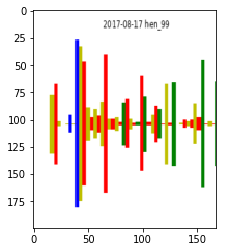

In [7]:
plt.imshow(image)

In [8]:
x_test = np.array(x_test).reshape(len(x_test), len(x_test[0]), len(x_test[0][0]), len(x_test[0][0][0]))
x_test = x_test.astype('float32')
print(x_test.shape)

x_train = np.array(x_train).reshape(len(x_train), len(x_train[0]), len(x_train[0][0]), len(x_train[0][0][0]))
x_train = x_train.astype('float32')
print(x_train.shape)

(707, 200, 168, 3)
(6358, 200, 168, 3)


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) #transform 2D 28x28 matrix to 3D (28x28x1) matrix
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #inputs have to be between [0, 1]
x_test /= 255

img_size = x_train.shape[1]
total_pixels = img_size * img_size
translator_factor = 2
translator_layer_size = int(total_pixels/translator_factor)
middle_factor = 2
middle_layer_size = int(translator_layer_size/middle_factor)

inputs = keras.Input(shape=(img_size,img_size,1), name='cat_image')
x = layers.Flatten(name = 'flattened_cat')(inputs) #turn image to vector.

x = layers.Dense(translator_layer_size, activation='relu', name='encoder')(x)
x = layers.Dense(middle_layer_size, activation='relu', name='middle_layer')(x)
x = layers.Dense(translator_layer_size, activation='relu', name='decoder')(x)


outputs = layers.Dense(total_pixels, activation='relu', name='reconstructed_cat')(x)
outputs = layers.Reshape((img_size,img_size,1))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

In [9]:
x_train.shape

(6358, 200, 168, 3)

In [10]:
model = Sequential()
 
#1st convolution layer
model.add(Conv2D(16, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
, padding='same', input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
 
#2nd convolution layer
model.add(Conv2D(2,(5, 5), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4), padding='same'))

#3nd convolution layer
#model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#here compressed version
 
#4rd convolution layer
model.add(Conv2D(2,(5, 5), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((4, 4)))
 
#5rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#6rd convolution layer
#model.add(Conv2D(16,(3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(UpSampling2D((2, 2)))

model.add(Conv2D(x_train.shape[3],(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 168, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 200, 168, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 84, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 84, 2)        802       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 84, 2)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 21, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 21, 2)         102       
__________

In [11]:
id_ = 'test1_'+title
path_model = os.path.join(path_save_model_info,id_)
if not os.path.exists(path_model):
    os.makedirs(path_model)

In [12]:
#if not enough improvment on the val loss, then we will reduce the learning rate, and after that if still no change then 
#early stopping 

#The checkpoint only includes the model weights
#save the network weights only when there is an improvement in classification accuracy on the validation dataset 
filepath = os.path.join(path_save_model_info,id_,'weights-improvement-{epoch:02d}-{val_loss:.2f}.h5')
#if save_best_only=True, the latest best model according to the quantity monitored will not be overwritten
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_loss', 
                                             verbose=1, 
                                             save_best_only=False, 
                                             mode='max')

#to reduce learning rate (new_lr = lr*factor) when a metric has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              patience=1, #patience before changing learning rate
                                              min_delta=0.0001,
                                              verbose=1,
                                              factor=0.1)

#Stop training when a monitored quantity has stopped improving. to avoid overfiting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.001, 
                                               patience=3,
                                               verbose=1, 
                                               mode='auto',
                                               baseline=None)

#create logs data for tensorboard usage
tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(path_log,id_), 
                                          histogram_freq=0, #no histo
                                          write_graph=True, 
                                          write_grads=False,
                                          write_images=True)

callbacks_list = [reduce_lr, early_stopping, checkpoint, tensorboard] 
#then as usuall to load weights to an instantiate model: model.load_weights("weights.best.hdf5")

In [13]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy') #'adadelta' Adam(lr=0.001)
model.fit(x_train, x_train, epochs=100, validation_data=(x_test, x_test), callbacks=callbacks_list)

Train on 6358 samples, validate on 707 samples
Epoch 1/100
6358/6358 [==============================] - ETA: 9:29 - loss: 0.693 - ETA: 4:54 - loss: 0.692 - ETA: 3:23 - loss: 0.692 - ETA: 2:37 - loss: 0.691 - ETA: 2:09 - loss: 0.689 - ETA: 1:51 - loss: 0.687 - ETA: 1:37 - loss: 0.683 - ETA: 1:27 - loss: 0.679 - ETA: 1:20 - loss: 0.674 - ETA: 1:13 - loss: 0.668 - ETA: 1:08 - loss: 0.661 - ETA: 1:04 - loss: 0.653 - ETA: 1:00 - loss: 0.644 - ETA: 57s - loss: 0.634 - ETA: 54s - loss: 0.62 - ETA: 52s - loss: 0.60 - ETA: 50s - loss: 0.59 - ETA: 48s - loss: 0.58 - ETA: 46s - loss: 0.56 - ETA: 45s - loss: 0.55 - ETA: 43s - loss: 0.54 - ETA: 42s - loss: 0.52 - ETA: 41s - loss: 0.51 - ETA: 40s - loss: 0.50 - ETA: 39s - loss: 0.50 - ETA: 38s - loss: 0.49 - ETA: 37s - loss: 0.48 - ETA: 36s - loss: 0.47 - ETA: 35s - loss: 0.47 - ETA: 34s - loss: 0.46 - ETA: 34s - loss: 0.45 - ETA: 33s - loss: 0.45 - ETA: 32s - loss: 0.44 - ETA: 32s - loss: 0.44 - ETA: 31s - loss: 0.43 - ETA: 31s - loss: 0.43 - ETA: 

6358/6358 [==============================] - ETA: 21s - loss: 0.20 - ETA: 22s - loss: 0.18 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.16 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.10 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.11 - ETA: 22s - loss: 0.12 - ETA: 22s - loss: 0.11 - ETA: 22s - loss: 0.11 - ETA: 22s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.11 - ETA: 20s - loss: 0.12 - ETA: 20s - loss: 0.12 - ETA: 20s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.11 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.11 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.11 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 22s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 20s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.10 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.10 - ETA: 22s - loss: 0.09 - ETA: 22s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.11 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.

6358/6358 [==============================] - ETA: 21s - loss: 0.12 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.10 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.09 - ETA: 21s - loss: 0.10 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 20s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 19s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 18s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.09 - ETA: 17s - loss: 0.

In [14]:
#save all the architecture, weights etc
model.save(os.path.join(path_save_model_info,id_,'model_all_'+title+'.h5')) 
#model = load_model(os.path.join(path_save_model_info,id_,'model_all.h5'))

In [15]:
#Once TensorBoard is running, navigate your web browser to localhost:6006 to view the TensorBoard.
#tensorboard --logdir=D:\vm_exchange\AVIFORUM\data\extracted_info_mobility_VF\visual\FF_model_info\FF_model_logs

### restored images

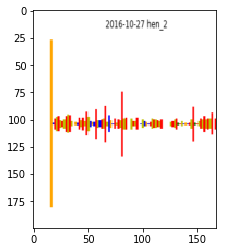

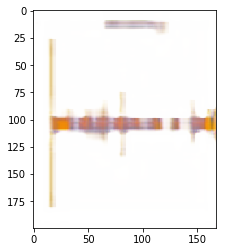

----------------------------


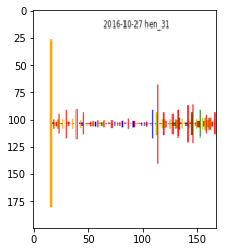

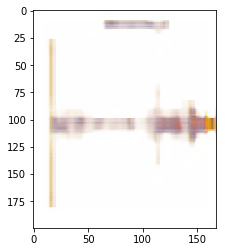

----------------------------


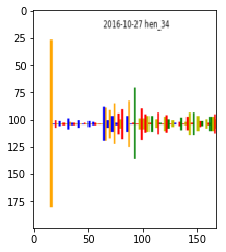

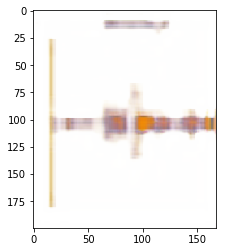

----------------------------


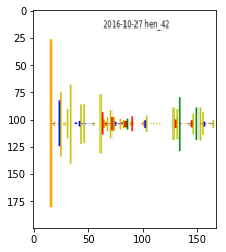

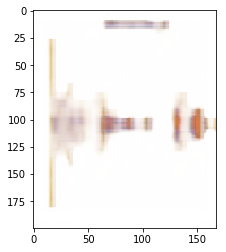

----------------------------


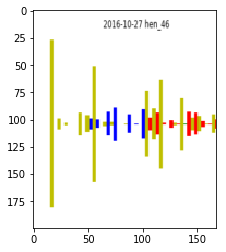

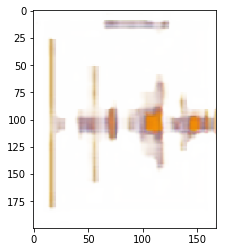

----------------------------


In [16]:
restored_imgs = model.predict(x_test)
for i in range(5):
    plt.imshow(x_test[i])
    plt.show()
    plt.imshow(restored_imgs[i])
    plt.show()
    print("----------------------------")

### define K-means

In [17]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
    7 #num of clusters
    , distance_metric = clustering_ops.SQUARED_EUCLIDEAN_DISTANCE
    , initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT
)

Instructions for updating:
Please use tf.contrib.factorization.KMeansClustering instead of tf.contrib.learn.KMeansClustering. It has a similar interface, but uses the tf.estimator.Estimator API instead of tf.contrib.learn.Estimator.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020911D7CEB8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600

### fit k-means

In [18]:
int(model.layers[7].output.shape[1])

25

In [19]:
print(x_test.shape)
x_test_pp = x_test[0:600].copy()
print(x_test_pp.shape)
print(model.layers[0].input)
print(model.layers[7].input)

(707, 200, 168, 3)
(600, 200, 168, 3)
Tensor("conv2d_input:0", shape=(?, 200, 168, 3), dtype=float32)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 25, 21, 2), dtype=float32)


In [ ]:
#layers = len(model.layers)
#for i in range(layers):
#    print(i, ". ", model.layers[i].output.get_shape())
#layer[7] is a compressed representation. It is size of (None, 7, 7, 2). this means 2 different 7x7 sized matrixes. We will 
#flatten these matrixes.
vo = model.layers[7].output.shape
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[7].output])
compressed = get_3rd_layer_output([x_test_pp])[0]
compressed = compressed.reshape(x_test_pp.shape[0],int(vo[1])*int(vo[2])*int(vo[3]))

def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

unsupervised_model.fit(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Public\Documents\Wondershare\CreatorTemp\tmpkcote1tl\model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Public\Documents\Wondershare\CreatorTemp\tmpkcote1tl\model.ckpt.
INFO:tensorflow:loss = 484562.03, step = 1
INFO:tensorflow:global_step/sec: 0.705946
INFO:tensorflow:loss = 284067.12, step = 101 (141.654 sec)
INFO:tensorflow:global_step/sec: 0.705835
INFO:tensorflow:loss = 283633.88, step = 201 (141.676 sec)
INFO:tensorflow:global_step/sec: 0.704962
INFO:tensorflow:loss = 283454.75, step = 301 (141.852 sec)


In [ ]:
#save all the architecture, weights etc
unsupervised_model.save(os.path.join(path_save_model_info,id_,'unsupervised_model_all.h5')) 
#model = load_model(os.path.join(path_save_model_info,id_,'model_all.h5'))

### clustering the test sample

In [ ]:
clusters = unsupervised_model.predict(input_fn=train_input_fn)
import scipy.misc
id_img = 0
for k,i in tqdm.tqdm(enumerate(clusters)):
    cluster_id = i['cluster_idx']
    id_img = id_img+1
    features = x_test_pp[k]
    path_class_ = os.path.join(path_class, title, str(cluster_id))
    if not os.path.exists(path_class_):
        os.makedirs(path_class_)
    scipy.misc.imsave(os.path.join(path_class_,str(id_img)+'.png'), features)

### clustering all

for j in range(0, x_train.shape[0], 500):
    X = x_train[j-500,j]
    compressed = get_3rd_layer_output([X])[0]
    compressed = compressed.reshape(X.shape[0],int(vo[1])*int(vo[2])*int(vo[3]))

    def train_input_fn():
        data = tf.constant(compressed, tf.float32)
        return (data, None)

    clusters = unsupervised_model.predict(input_fn=train_input_fn)
    id_img = 0
    for k,i in tqdm.tqdm(enumerate(clusters)):
        cluster_id = i['cluster_idx']
        id_img = id_img+1
        features = X[k]
        path_class_ = os.path.join(path_class, title, str(cluster_id))
        if not os.path.exists(path_class_):
            os.makedirs(path_class_)
        scipy.misc.imsave(os.path.join(path_class_,str(id_img)+'.png'), features)